In [1]:
from pixell import utils, enmap, bunch, reproject, colors, coordinates

import numpy as np

import h5py
import os
    
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import map_utils as utils
from optical_loading import pwv_interp, bandpass_interp
from abscal import T_b

import dill as pk

from sotodlib import core

from glob import glob

from astropy.modeling import models
from astropy import units as u
import astropy.constants as consts
from astropy.convolution import convolve, Gaussian2DKernel

from scipy.integrate import quad
from scipy.interpolate import interp1d

# Display inline plots
%matplotlib inline

%load_ext autoreload
%autoreload 2

/so/home/jorlo/venvs/sotodlib/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Matthew Cals

In [92]:
fpath="/so/home/saianeesh/data/beams/lat/source_maps/per_obs/fits/beam_pars.h5"
f = h5py.File(fpath, mode="r")                                         
obs_ids = []                                            
times = []                                              
stream_ids = []                                         
bands = []                                              
for o in f.keys():                                     
    for s in f[o].keys():                                 
        for b in f[o][s].keys():                        
            obs_ids += [o]                              
            times += [float(o.split("_")[1])]            
            stream_ids += [s]                              
            bands += [b]  
limit_bands = ["f090", "f150", "f220", "f280"]            
msk = np.isin(bands, limit_bands)                         
obs_ids = np.array(obs_ids)[msk]                         
times = np.array(times)[msk]                             
stream_ids = np.array(stream_ids)[msk]                   
bands = np.array(bands)[msk]    

amans = np.array([
    core.AxisManager.load(f[os.path.join(o, s, b)])
    for o, s, b in zip(obs_ids, stream_ids, bands)
])


fpath="/so/home/saianeesh/data/beams/lat/source_maps/pointing_model/fits/beam_pars.h5"
f = h5py.File(fpath, mode="r")                                                                                                                                                                                                                                                              
obs_ids_2 = []                                            
times_2 = []                                              
stream_ids_2 = []                                         
bands_2 = []     

for o in f.keys():                                                                                                                                                                                                                                                                          
    for s in f[o].keys():                                                                                                                                                                                                                                                                   
        for b in f[o][s].keys(): 
            keep = True
            for i in range(len(obs_ids)):
                if obs_ids[i] == o and stream_ids[i] == s and bands[i] == b:
                    keep = False
                    continue
            if keep:
                obs_ids_2 += [o]                                                                                                                                                                                                                                                                  
                times_2 += [float(o.split("_")[1])]                                                                                                                                                                                                                                               
                stream_ids_2 += [s]                                                                                                                                                                                                                                                               
                bands_2 += [b] 

limit_bands = ["f090", "f150", "f220", "f280"]            
msk = np.isin(bands_2, limit_bands)                         
obs_ids_2 = np.array(obs_ids_2)[msk]                         
times_2 = np.array(times_2)[msk]                             
stream_ids_2 = np.array(stream_ids_2)[msk]                   
bands_2 = np.array(bands_2)[msk]                            

amans_2 = np.array([
    core.AxisManager.load(f[os.path.join(o, s, b)])
    for o, s, b in zip(obs_ids_2, stream_ids_2, bands_2)
])

amans = np.append(amans, amans_2)  

In [194]:
obs_id = "1750682425"
path = "/so/home/saianeesh/data/beams/lat/source_maps/per_obs/mars/{}/".format(obs_id[:5])
#path = "/so/home/saianeesh/data/first_light_unfocused/source_maps/mars/"

ot = "i3"
obs = f"obs_{obs_id}_lat{ot}_111/"

glob(path+obs+"*_solved.fits")

[]

In [131]:

wafer = "mv13"
band = "090"
map_file = f"obs_{obs_id}_lat{ot}_111_ufm_{wafer}_f{band}"
solved = enmap.read_map(path+obs+map_file+"_solved.fits")[0]
weights = enmap.read_map(path+obs+map_file+"_weights.fits")[0][0]
binned = enmap.read_map(path+obs+map_file+"_binned.fits")[0]


In [132]:
if "mv" in wafer:
    ufm_type = "MF"
    if band == "090":
        ufm_band = "MF_1"
    elif band == "150":
        ufm_band = "MF_2"
elif "uv" in wafer:
    ufm_type = "UHF"
    if band == "220":
        ufm_band = "UHF_1"
    elif band == "280":
        ufm_band = "UHF_2"
else:
    ufm_type = "LF"
    if band == "030":
        ufm_band = "LF_1"
    elif band == "040":
        ufm_band = "LF_2"


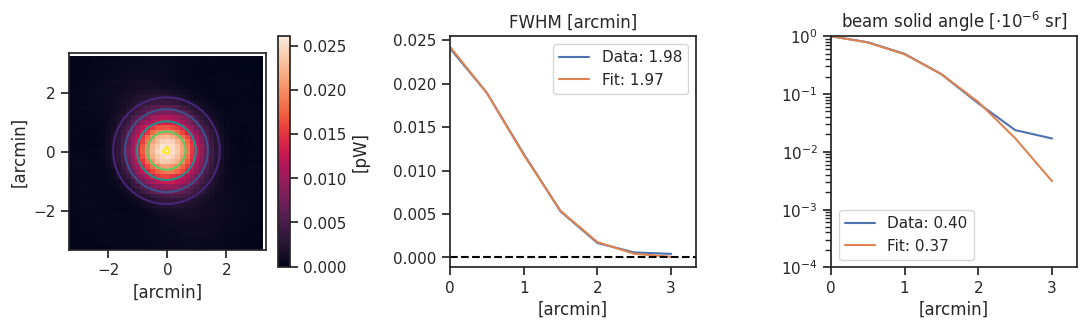

In [133]:


kernel = Gaussian2DKernel(5)
smoothed = convolve(solved, kernel)
cent = np.argmax(smoothed)
cent = np.unravel_index(cent, solved.shape)
pixsize = np.abs(solved.wcs.wcs.cdelt[0]*60)

r = 20
solved = solved[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
weights = weights[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
binned = binned[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
#plt.imshow(solved)
#plt.colorbar()
pixmap = enmap.pixmap(solved.shape, solved.wcs)
fitted_amp, shift_x, shift_y, fitted_fwhm, data_solid_angle, chisred, popt, pcov, radii_data, means_data, means_fit = utils.fit_gauss_pointing(solved, weights, pixmap, make_plots=True)




In [134]:
fitted_amp

np.float64(0.02644639312889984)

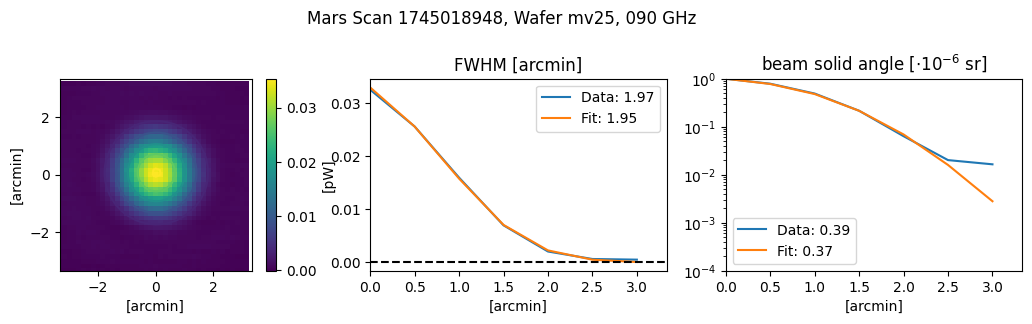

In [82]:
data_fitted = utils.gauss(pixmap.astype(float), *popt).reshape(solved.shape)
max_val = np.max(solved)
min_val = np.min(solved)
mult_factor = (solved.wcs.wcs.cdelt[1] * (60))
fwhm = np.sqrt(popt[3]) * 2 * np.sqrt(2 * np.log(2)) * mult_factor

res = pixmap.wcs.wcs.cdelt[1] * 60 # convert to arcmin
n_pix = solved.shape[0]
span = n_pix * res
x_vals = np.arange(-span / 2, span / 2, res)
y_vals = np.arange(-span / 2, span / 2, res)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)

radii_data, means_data = utils.rad_avg(x_vals, y_vals, solved, 0, span/2, 0.5, 
                                 shift_center=[-shift_x * res, -shift_y * res])
radii_fit, means_fit = utils.rad_avg(x_vals, y_vals, data_fitted, 0, span/2, 0.5, 
                               shift_center=[-shift_x * res, -shift_y * res])
data_fwhm = utils.get_fwhm_radial_bins(radii_data, means_data, interpolate=True)

y_centered_integrand = y_vals[:, 0] + shift_y * res
x_centered_integrand = x_vals[0] + shift_x * res

data_solid_angle = utils.solid_angle(x_centered_integrand, y_centered_integrand, utils.normalize(solved)) * (1e6)

fit_sigma = utils.arcmin2rad(np.sqrt(popt[3]) * mult_factor)
fit_solid_angle = 2 * np.pi * (fit_sigma ** 2) * (1e6)

fig, ax = plt.subplots(1, 3, figsize=(13, 3))
plt.subplot(1, 3, 1)

plt.gca().set_aspect('equal')

plt.pcolormesh(x_vals, y_vals, solved, vmin=min_val, vmax=np.max(solved))
plt.xlim(-span/2, span/2)
plt.ylim(-span/2, span/2)
plt.xlabel('[arcmin]')
plt.ylabel('[arcmin]')
plt.colorbar(label='[pW]')

levels=[max_val * 0.1, max_val * .25, max_val * .5,
        max_val * 0.75, max_val]

cs = plt.contour(x_vals, y_vals, data_fitted,
                 cmap='viridis', vmin=min_val,
                 vmax=max_val, levels=levels)

plt.subplot(1, 3, 2)

plt.plot(radii_data, means_data, label=f"Data: {data_fwhm:.2f}")
plt.plot(radii_fit, means_fit, label=f"Fit: {fwhm:.2f}")
plt.title(f'FWHM [arcmin]')
plt.axhline(0, ls="--", color="black")
plt.xlabel('[arcmin]')
plt.xlim(0, span/2)
plt.legend()

plt.subplot(1, 3, 3)

plt.plot(radii_data, utils.normalize(means_data), label=f"Data: {data_solid_angle:.2f}")
plt.plot(radii_data, utils. normalize(means_fit), label=f"Fit: {fit_solid_angle:.2f}")
plt.title(fr'beam solid angle [$\cdot 10^{{-6}}$ sr]')
plt.legend()
plt.ylim(1e-4, 1)
plt.yscale('log')
plt.xlabel('[arcmin]')
plt.xlim(0, span/2)

fig.suptitle("Mars Scan {}, Wafer {}, {} GHz".format(obs_id, wafer, band))
fig.subplots_adjust(top=0.75)
plt.savefig("plts/beams/{}_{}_{}.png".format(obs_id, wafer, band), dpi=600, bbox_inches='tight')
plt.savefig("plts/beams/{}_{}_{}.pdf".format(obs_id, wafer, band), dpi=600, bbox_inches='tight')

plt.show()

In [83]:
fitted_amp = beam_dict[map_file[4:]]["amp"]
data_solid_angle = beam_dict[map_file[4:]]["omega"]
chisred = beam_dict[map_file[4:]]["chisred"]

NameError: name 'beam_dict' is not defined

In [84]:
if chisred >= 100:
    print("WARNING: HIGH CHISQ RED")

# Scale Observed Amp to 1mm PWV, el = 50 deg

In [85]:
import datetime as dt

from so3g.hk import load_range
import requests
from io import StringIO

with open("atmosphere_eff.pk", "rb") as f:
    atmosphere_eff = pk.load(f)
# If you have more than one observation, you can load PWV between the start and end timestamps
# otherwise set the start and end to the same obs

start_timestamp = int(obs_id)
end_timestamp = int(obs_id)

start_date = dt.datetime.utcfromtimestamp(start_timestamp) - dt.timedelta(days=1)
end_date = dt.datetime.utcfromtimestamp(end_timestamp) + dt.timedelta(days=1)

fiducial_elevation = 50
fiducial_pwv = 1 # mm

el_key = "50" #hardcoded :(
pwv_idx = np.where(np.array([np.abs(pwv - fiducial_pwv) < 0.1 for pwv in atmosphere_eff['pwv']]))[0]


In [86]:
pwv = pwv_interp()

In [87]:
pwv_obs = pwv(obs_id)

ctx = core.Context('/so/metadata/lat/contexts/smurf_detsets.yaml')
meta = ctx.get_meta(obs.strip("/"))

el_obs = meta.obs_info.el_center

In [88]:
obs_idx_pwv = np.where(np.isclose(np.abs(atmosphere_eff['pwv'] - pwv_obs), np.min(np.abs(atmosphere_eff['pwv'] - pwv_obs))))[0][0]
obs_key_el = [el for el in atmosphere_eff['LF']["LF_1"].keys() if np.abs(int(el) - el_obs) < 2.5][0]

In [89]:
t_atm_obs = atmosphere_eff[ufm_type][ufm_band][obs_key_el][obs_idx_pwv]
t_atm_fiducial = atmosphere_eff[ufm_type][ufm_band][el_key][pwv_idx]

In [90]:
pwv_adjust = t_atm_fiducial / t_atm_obs

## Scale to fiducial size

In [ ]:

mars_diameter = utils.get_planet_diameter(int(obs_id), "Mars") # arcsec, we are using exact temperatures


## Calculate abs cal

In [97]:
def data_to_cal_factor(p_meas, beam_solid_angle, band, wafer, mars_diameter, obs_id):
    fiducial_solid_angle = utils.angular_diameter_to_solid_angle(mars_diameter)

    timestamp = str(obs_id)
    planet_temp = T_b[timestamp]
    
    fill_factor = (fiducial_solid_angle / (beam_solid_angle * 1e-6))
    t_eff_planet = planet_temp[band] *fill_factor
    cal_factor = t_eff_planet / p_meas # K -> pW
    
    bandpass = bandpasses[band]
    
    opt_eff = ((1/(cal_factor)*u.pW/u.K)/(consts.k_B * bandpass * u.GHz)).to(1)
    
    #power, _ = quad(integrand, 0, 350)*bb(200e9).unit*u.GHz
    #opt_eff =fitted_amp/(power.to(u.pW/u.m**2/u.sr) * fill_factor * (float(150) * u.GHz).to(u.m, equivalencies=u.spectral())**2)
    
    return cal_factor, opt_eff

adjusted_amplitude = fitted_amp * pwv_adjust[0]

cal_factor, opt_eff = data_to_cal_factor(adjusted_amplitude, data_solid_angle, band, wafer, mars_diameter, obs_id)
raw_factor, _ = data_to_cal_factor(fitted_amp, data_solid_angle, band, wafer, mars_diameter, obs_id)

print(f"Measured calibration factor = {cal_factor:.2f} K -> pW (RJ Units)")
print(f"Measured optical efficiency = {opt_eff:.3f}")
#print(f"Efficiency from inst model = {efficiency * 100:.2f} %")

#with open("abscals.pk", "rb") as f:
#    abscal_dict = pk.load(f)
    
#abscal_dict[map_file] = cal_factor

#with open("abscals.pk", "wb") as f:
#    pk.dump(abscal_dict, f)

0.0024114200687378857
0.0024114200687378857
Measured calibration factor = 12.39 K -> pW (RJ Units)
Measured optical efficiency = 0.203


In [26]:
result_dict["mv11"]["090"]["obs"]

['mv11_090_1747858471',
 'mv11_090_1750321357',
 'mv11_090_1750338001',
 'mv11_090_1750357179',
 'mv11_090_1750374641',
 'mv11_090_1750377906',
 'mv11_090_1750424174',
 'mv11_090_1750510346',
 'mv11_090_1750547338',
 'mv11_090_1750550568',
 'mv11_090_1750633711',
 'mv11_090_1750720029',
 'mv11_090_1750723231']

In [93]:
with open("r3v8_sim.pk", "rb") as f:
    sim = pk.load(f)

for flavor in ['MF', 'UHF']:
    for kind in ['baseline', 'goal']:
        print(flavor, kind)
        for ch in sim[flavor][kind].keys():
            print("\t", ch, f"eta={sim[flavor][kind][ch]['det_eff']}  ", 'K_RJ / pW', 1.0/(1e12*sim[flavor][kind][ch]['dpdt_rj']) )

MF baseline
	 MF_1 eta=0.974   K_RJ / pW 18.871016107107586
	 MF_2 eta=0.57   K_RJ / pW 9.911860127294345
MF goal
	 MF_1 eta=1.08   K_RJ / pW 14.38473230901672
	 MF_2 eta=0.669   K_RJ / pW 7.624657050421212
UHF baseline
	 UHF_1 eta=0.581   K_RJ / pW 5.317190203726212
	 UHF_2 eta=0.636   K_RJ / pW 4.72122772765332
UHF goal
	 UHF_1 eta=0.74   K_RJ / pW 3.283290861516907
	 UHF_2 eta=0.718   K_RJ / pW 3.5883133394803957


# Bandpasses

In [6]:
from optical_loading import bandpass_interp,get_bandwidth
import pandas as pd

In [81]:
band = "090"

path="/so/home/jorlo/data/lat_bandpasses/"
if band == "090" or band == "150":
    df = pd.read_csv(path + "LAT_MF_bands.csv")
elif band == "220" or band == "280":
    df = pd.read_csv(path + "LAT_UHF_bands.csv")

In [82]:
arrays = [key.split("_")[0] for key in df.keys() if key != "frequency"]

In [83]:
passes = np.zeros(len(arrays))
for i, array in enumerate(arrays):
    bandpass = bandpass_interp(band, array)
    x = np.linspace(50, 350, 10000)
    y = bandpass(x)
    y /= np.amax(y)
    passes[i] = np.trapezoid(y, x)

In [84]:
np.mean(passes)

np.float64(29.830827370187357)

In [87]:
bandpass = bandpass_interp("150", "mean")

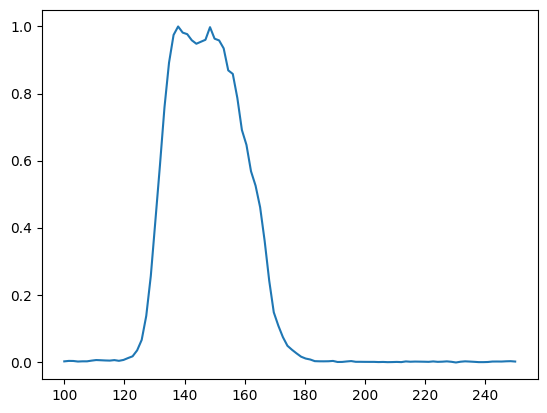

In [90]:
x = np.linspace(100,250, 100)
y = bandpass(x)

plt.plot(x,y/np.amax(y))
#plt.vlines((135, 135+29.5), 0, 1)

# Saturn Model

In [ ]:
x = [100, 143, 217, 353, 545]
_y = [148.5, 147.6, 142.1, 133.0, 86.7] #Planck results; https://www.aanda.org/articles/aa/pdf/2017/11/aa30311-16.pdf, Table 4, ring only
y = [143.2, 143.6, 139.7, 133.1, 89.8] #Table 4, system

def sat_model(x, a, k, c):
    return a*x**k + c
import scipy

popt, pcov = scipy.optimize.curve_fit(sat_model, x, y, p0=[1e-10, 4, 150])

xspace = np.linspace(100, 545, 1000)

plt.scatter(x, y)
plt.plot(xspace, sat_model(xspace, *popt))

# Results

In [2]:
with open("results_10032025.pk", "rb") as f:
    result_dict = pk.load(f)
    
with open("r3v8_sim.pk", "rb") as f:
    sim = pk.load(f)


c_base = (220/255, 50/255, 32/255)
c_goal = (0/255, 90/255, 181/255)


In [3]:
labels = []
cals = []
obs = []
pwvs = []
data_omegas = []
fwhms = []
sources = []

pwv = pwv_interp()

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for ufm in ufms:
        for key in result_dict.keys():
            if ufm not in key:
                continue
            for sub_key in result_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_cals = np.array(result_dict[key][sub_key]["cal"])
                cur_obs = np.array(result_dict[key][sub_key]["obs"])
                cur_omegas = np.array(result_dict[key][sub_key]["omega_data"])
                cur_sources = np.array(result_dict[key][sub_key]["source"])
                cur_fwhms = np.array(result_dict[key][sub_key]["fwhm"])

                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_cals)):
                    cur_pwv = pwv(cur_obs[j].split("_")[2])
                    cals.append(cur_cals[j])
                    labels.append(label)
                    obs.append(cur_obs[j])
                    pwvs.append(cur_pwv)
                    data_omegas.append(cur_omegas[j])
                    sources.append(cur_sources[j])
                    fwhms.append(cur_fwhms[j])
                    
labels = np.array(labels)
cals = np.array(cals)
obs = np.array(obs)
pwvs = np.array(pwvs)
data_omegas = np.array(data_omegas)                                      
sources = np.array(sources)                                      
fwhms = np.array(fwhms)                                      

df = pd.DataFrame({'labels': labels, 'cals': cals, 'obs': obs, 'pwvs':pwvs, "omegas":data_omegas, "sources":sources,"fwhms":fwhms})
    

In [29]:
np.unique(labels)

array(['090_mv11', '090_mv13', '090_mv14', '090_mv20', '090_mv21',
       '090_mv24', '090_mv25', '090_mv26', '090_mv28', '090_mv32',
       '090_mv34', '090_mv49', '150_mv11', '150_mv13', '150_mv14',
       '150_mv20', '150_mv21', '150_mv24', '150_mv25', '150_mv26',
       '150_mv28', '150_mv32', '150_mv34', '150_mv49', '220_uv31',
       '220_uv38', '220_uv39', '220_uv42', '220_uv46', '220_uv47',
       '280_uv31', '280_uv38', '280_uv39', '280_uv42', '280_uv46',
       '280_uv47'], dtype='<U8')

In [33]:
my_labels = np.unique(labels)
mars_cals = np.zeros(len(my_labels))
sat_cals = np.zeros(len(my_labels))
mars_std = np.zeros(len(my_labels))
sat_std = np.zeros(len(my_labels))

for i, label in enumerate(my_labels):
    mars_cals[i] = np.nanmean(df.where(df["labels"].str.contains(label)).where(df["sources"]=="mars").cals)
    sat_cals[i] = np.nanmean(df.where(df["labels"].str.contains(label)).where(df["sources"]=="saturn").cals)
    mars_std[i] = np.nanstd(df.where(df["labels"].str.contains(label)).where(df["sources"]=="mars").cals)
    sat_std[i] = np.nanstd(df.where(df["labels"].str.contains(label)).where(df["sources"]=="saturn").cals)
    #print(np.nanmean(df.where(df["labels"].str.contains(label)).where(df["sources"]=="mars").cals), np.nanmean(df.where(df["labels"].str.contains(label)).where(df["sources"]=="saturn").cals))

/tmp/ipykernel_203359/939895445.py:9: RuntimeWarning: Mean of empty slice
  sat_cals[i] = np.nanmean(df.where(df["labels"].str.contains(label)).where(df["sources"]=="saturn").cals)
/so/home/jorlo/venvs/sotodlib/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [39]:
temp = df.where(df["labels"].str.contains("090_mv11")).where(df["sources"]=="mars").cals.to_numpy()

(array([1., 3., 5., 8., 7., 3., 0., 1., 1., 1.]),
 array([ 8.07963055,  9.58706103, 11.0944915 , 12.60192198, 14.10935245,
        15.61678292, 17.1242134 , 18.63164387, 20.13907435, 21.64650482,
        23.1539353 ]),
 <BarContainer object of 10 artists>)

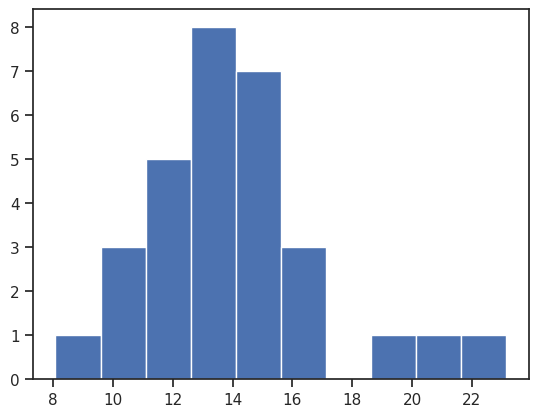

In [41]:
plt.hist(temp)

In [42]:
np.nanstd(temp)

np.float64(2.951412670895262)

<ErrorbarContainer object of 3 artists>

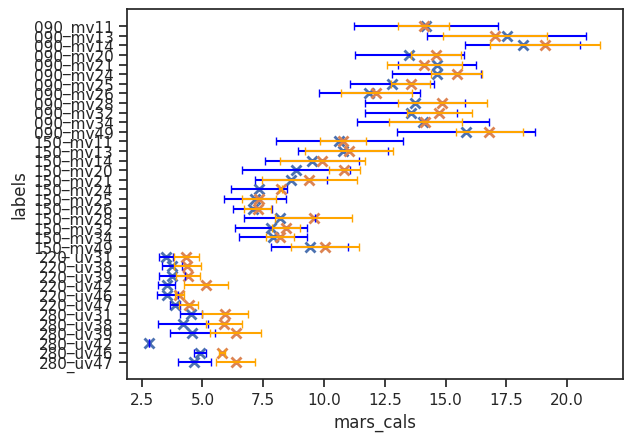

In [44]:
my_df = pd.DataFrame({"labels":my_labels, "mars_cals":mars_cals, "sat_cals":sat_cals, "mars_std":mars_std, "sat_std":sat_std})

fig, ax = plt.subplots()
sns.pointplot(data=my_df, y="labels", x="mars_cals", linestyle="none", marker="x", ax=ax,)
sns.pointplot(data=my_df, y="labels", x="sat_cals", linestyle="none", marker="x", ax=ax,)

ax.errorbar(
    x=my_df['mars_cals'],
    y=my_df['labels'],
    xerr=my_df['mars_std'], # Your pre-calculated errors
    fmt='none', # No line connecting points
    color='blue',
    capsize=3
)

ax.errorbar(
    x=my_df['sat_cals'],
    y=my_df['labels'],
    xerr=my_df['sat_std'], # Your pre-calculated errors
    fmt='none', # No line connecting points
    color='orange',
    capsize=3
)

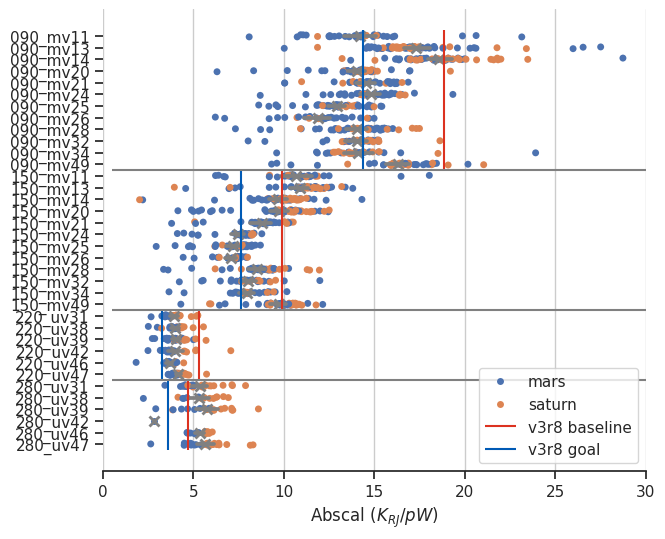

In [4]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
#ax.set_xscale("log")

# Load the example planets dataset
#planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
#sns.boxplot(
#    planets, x="distance", y="method", hue="method",
#    whis=[0, 100], width=.6, palette="vlag"
#)

# Add in points to show each observation
sns.stripplot(df.where((df.pwvs < 3) & (df.cals<50)), x="cals", y="labels", hue="sources", zorder=1) #note somewhat nasty cut on cals since neptune keeps slipping into our saturn obs
sns.pointplot(data=df.where((df.pwvs < 3) & (df.cals<50)), x="cals", y="labels", linestyle="none", marker="x", color="0.5", zorder=2)

ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()

pos_090 = len([label for label in set(df.labels.to_numpy()) if "090" in label]) - 0.5
pos_150 = pos_090 + len([label for label in set(df.labels.to_numpy()) if "150" in label])
pos_220 = pos_150 + len([label for label in set(df.labels.to_numpy()) if "220" in label])
pos_280 = pos_220 + len([label for label in set(df.labels.to_numpy()) if "280" in label])

plt.vlines(1.0/(1e12*(sim["MF"]["baseline"]["MF_1"]["dpdt_rj"])), ymin = ymin, ymax = pos_090, label="v3r8 baseline", color=c_base)
plt.vlines(1.0/(1e12*(sim["MF"]["goal"]["MF_1"]["dpdt_rj"])), ymin = ymin, ymax = pos_090, label="v3r8 goal", color=c_goal)

plt.vlines(1.0/(1e12*(sim["MF"]["baseline"]["MF_2"]["dpdt_rj"])), ymin = pos_090, ymax = pos_150, label=None, color=c_base)
plt.vlines(1.0/(1e12*(sim["MF"]["goal"]["MF_2"]["dpdt_rj"])), ymin = pos_090, ymax = pos_150, label=None, color=c_goal)

plt.vlines(1.0/(1e12*(sim["UHF"]["baseline"]["UHF_1"]["dpdt_rj"])), ymin = pos_150, ymax = pos_220, label=None, color=c_base)
plt.vlines(1.0/(1e12*(sim["UHF"]["goal"]["UHF_1"]["dpdt_rj"])), ymin = pos_150, ymax = pos_220, label=None, color=c_goal)

plt.vlines(1.0/(1e12*(sim["UHF"]["baseline"]["UHF_2"]["dpdt_rj"])), ymin = pos_220, ymax = ymax, label=None, color=c_base)
plt.vlines(1.0/(1e12*(sim["UHF"]["goal"]["UHF_2"]["dpdt_rj"])), ymin = pos_220, ymax = ymax, label=None, color=c_goal)

plt.hlines([pos_090, pos_150, pos_220], xmin=xmin, xmax=xmax, color="0.5")

plt.xlim(0, 30)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="Abscal ($K_{RJ}/pW$)", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
#f.savefig("./plts/new_abscal/abscal.pdf", dpi=600, bbox_inches='tight')
#f.savefig("./plts/new_abscal/abscal.png", dpi=600, bbox_inches='tight')


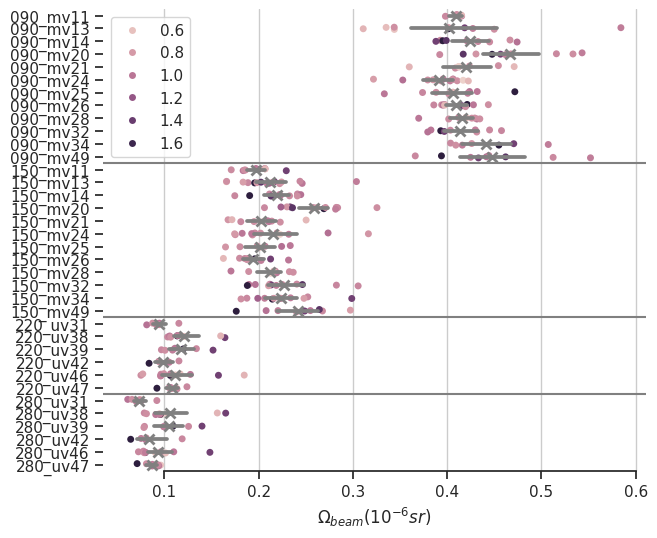

In [229]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
#ax.set_xscale("log")

ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()

pos_090 = len([label for label in set(df.labels.to_numpy()) if "090" in label]) - 0.5
pos_150 = pos_090 + len([label for label in set(df.labels.to_numpy()) if "150" in label])
pos_220 = pos_150 + len([label for label in set(df.labels.to_numpy()) if "220" in label])
pos_280 = pos_220 + len([label for label in set(df.labels.to_numpy()) if "280" in label])

plt.hlines([pos_090, pos_150, pos_220], xmin=xmin, xmax=xmax, color="0.5")
# Add in points to show each observation
sns.stripplot(df.where(df.pwvs < 2), x="omegas", y="labels", hue="pwvs", zorder=1)
sns.pointplot(data=df.where(df.pwvs < 2), x="omegas", y="labels", linestyle="none", marker="x", color="0.5", zorder=2)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="$\Omega_{beam} (10^{-6} sr)$", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
f.savefig("./plts/abscal/omegas.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/abscal/omegas.png", dpi=600, bbox_inches='tight')


# Make Result Dict

In [221]:
if False: #Yes this is dumb but it stops you from accidentally remaking the dict when you run all cells
    with open("abscals.pk", "rb") as f:
        abscal_dict = pk.load(f)
    result_dict = {}

    for key in abscal_dict.keys():
        ufm = key.split("_")[4]
        freq = key.split("_")[5]
        if ufm in result_dict.keys():
            continue
        if "090" in freq or "150" in freq:
            result_dict[ufm] = {"090":{"cal":[], "chi":[], "obs":[], "raw_cal":[], "el":[], "pwv":[], "fwhm":[], "raw_opt":[], "cal_opt":[], "omega_data":[]},
                                "150":{"cal":[], "chi":[], "obs":[], "raw_cal":[], "el":[], "pwv":[], "fwhm":[], "raw_opt":[], "cal_opt":[], "omega_data":[]}
                               }
        else:
            result_dict[ufm] = {"220":{"cal":[], "chi":[], "obs":[], "raw_cal":[], "el":[], "pwv":[], "fwhm":[], "raw_opt":[], "cal_opt":[], "omega_data":[]},
                                "280":{"cal":[], "chi":[], "obs":[], "raw_cal":[], "el":[], "pwv":[], "fwhm":[], "raw_opt":[], "cal_opt":[], "omega_data":[]},
                               }
    for key in abscal_dict.keys():
        ufm = key.split("_")[4]
        freq = key.split("_")[5][1:]
        result_dict[ufm][freq]["cal"].append(abscal_dict[key]["adj_cal"])
        result_dict[ufm][freq]["chi"].append(abscal_dict[key]["chi_beam"])
        result_dict[ufm][freq]["raw_cal"].append(abscal_dict[key]["raw_cal"])
        result_dict[ufm][freq]["el"].append(abscal_dict[key]["el"])
        result_dict[ufm][freq]["pwv"].append(abscal_dict[key]["pwv"])
        result_dict[ufm][freq]["obs"].append(key)
        result_dict[ufm][freq]["fwhm"].append(abscal_dict[key]["fwhm"])
        result_dict[ufm][freq]["raw_opt"].append(abscal_dict[key]["raw_opt"])
        result_dict[ufm][freq]["cal_opt"].append(abscal_dict[key]["cal_opt"])
        result_dict[ufm][freq]["omega_data"].append(abscal_dict[key]["omega_data"])
        
    with open("results_05292025.pk", "wb") as f:
        pk.dump(result_dict, f)

# Optical Efficiencies

In [230]:
with open("abscals.pk", "rb") as f:
    abscal_dict = pk.load(f)

In [231]:
labels = []
raw_opt = []
cal_opt = []
obs = []
chis = []
pwvs = []

pwv = pwv_interp()

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for ufm in ufms:
        for key in result_dict.keys():
            if ufm not in key:
                continue
            for sub_key in result_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_chis = np.array(result_dict[key][sub_key]["chi"])
                flags = np.where((25<= cur_chis) & (cur_chis<=1000))[0]
                cur_raw = np.array(result_dict[key][sub_key]["raw_opt"])[flags]
                cur_cal = np.array(result_dict[key][sub_key]["cal_opt"])[flags]
                cur_chis = cur_chis[flags]
                cur_obs = np.array(result_dict[key][sub_key]["obs"])[flags]

                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_raw)):
                    cur_pwv = pwv(cur_obs[j].split("_")[0])
                    raw_opt.append(cur_raw[j])
                    cal_opt.append(cur_cal[j])
                    chis.append(cur_chis[j])
                    labels.append(label)
                    obs.append(cur_obs[j])
                    pwvs.append(cur_pwv)


labels = np.array(labels)
raw_opt = np.array(raw_opt)
cal_opt = np.array(cal_opt)
chis = np.array(chis)
obs = np.array(obs)
pwvs = np.array(pwvs)

df = pd.DataFrame({'labels': labels, 'raw_opt': raw_opt, 'cal_opt':cal_opt, 'chis': chis, 'obs': obs, 'pwvs':pwvs})

In [241]:
((1e12*sim["MF"]["baseline"]["MF_1"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["090"] * u.GHz)).to(1)

<Quantity 0.13313026>

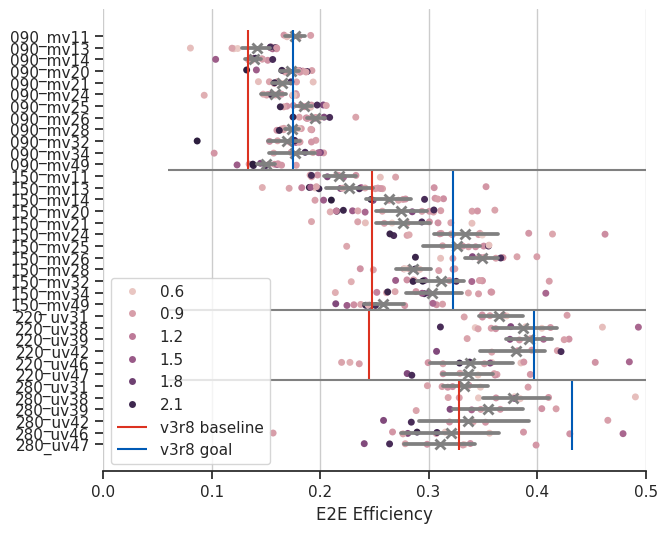

In [248]:

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))


# Add in points to show each observation
sns.stripplot(df.where(df.raw_opt <= 0.5), x="raw_opt", y="labels", hue="pwvs", zorder=1)
sns.pointplot(data=df.where(df.raw_opt <= 0.5), x="raw_opt", y="labels", linestyle="none", marker="x", color="0.5", zorder=2)

ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()

pos_090 = len([label for label in set(df.labels.to_numpy()) if "090" in label]) - 0.5
pos_150 = pos_090 + len([label for label in set(df.labels.to_numpy()) if "150" in label])
pos_220 = pos_150 + len([label for label in set(df.labels.to_numpy()) if "220" in label])
pos_280 = pos_220 + len([label for label in set(df.labels.to_numpy()) if "280" in label])

#plt.vlines(0.125, ymin = ymin, ymax = pos_090, label="v3r8 baseline", color=c_base)
#plt.vlines(0.191, ymin = pos_090, ymax = pos_150, label=None, color=c_base)
#plt.vlines(0.236, ymin = pos_150, ymax = pos_220, label=None, color=c_base)
#plt.vlines(0.272, ymin = pos_220, ymax = ymax, label=None, color=c_base)


#(1e12*sim["MF"]["baseline"]["MF_1"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpass * u.GHz).to(1)

plt.vlines(((1e12*sim["MF"]["baseline"]["MF_1"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["090"] * u.GHz)).to(1), ymin = ymin, ymax = pos_090, label="v3r8 baseline", color=c_base)
plt.vlines(((1e12*sim["MF"]["goal"]["MF_1"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["090"] * u.GHz)).to(1), ymin = ymin, ymax = pos_090, label="v3r8 goal", color=c_goal)

plt.vlines(((1e12*sim["MF"]["baseline"]["MF_2"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["150"] * u.GHz)).to(1), ymin = pos_090, ymax = pos_150, label=None, color=c_base)
plt.vlines(((1e12*sim["MF"]["goal"]["MF_2"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["150"] * u.GHz)).to(1), ymin = pos_090, ymax = pos_150, label=None, color=c_goal)

plt.vlines(((1e12*sim["UHF"]["baseline"]["UHF_1"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["220"] * u.GHz)).to(1), ymin = pos_150, ymax = pos_220, label=None, color=c_base)
plt.vlines(((1e12*sim["UHF"]["goal"]["UHF_1"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["220"] * u.GHz)).to(1), ymin = pos_150, ymax = pos_220, label=None, color=c_goal)

plt.vlines(((1e12*sim["UHF"]["baseline"]["UHF_2"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["280"] * u.GHz)).to(1), ymin = pos_220, ymax = ymax, label=None, color=c_base)
plt.vlines(((1e12*sim["UHF"]["goal"]["UHF_2"]["dpdt_rj"]*u.pW/u.K)/(consts.k_B * bandpasses["280"] * u.GHz)).to(1), ymin = pos_220, ymax = ymax, label=None, color=c_goal)


plt.hlines([pos_090, pos_150, pos_220], xmin=xmin, xmax=xmax, color="0.5")

plt.xlim(0, 0.5)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="E2E Efficiency", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
f.savefig("./plts/e2e_eff.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/e2e_eff.png", dpi=600, bbox_inches='tight')

## Solid Angles

# Abscal Metadata

In [2]:
from sotodlib import core
import sotodlib.io.metadata as io_meta


In [3]:
with open("results_07312025.pk", "rb") as f:
    result_dict = pk.load(f)


In [11]:
result_dict["mv11"]["090"]["obs"][0][9:]

'1747858471'

In [80]:
cals = []
raw_cals = []
data_freqs = []
data_ufms = []
cals_cmb = []
raw_cals_cmb = []
data_solid_angles = []
omegas = []
obs = []

pwv = pwv_interp()

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

flavor_dict = {"090": "MF_1",
               "150": "MF_2",
               "220": "UHF_1",
               "280": "UHF_2"
              }

for freq in freqs:
    temp_conv = utils.temp_conv(T_B=2.725*u.Kelvin, flavor=flavor_dict[freq].split("_")[0], ch=flavor_dict[freq], kind='baseline')
    for ufm in ufms:
        for key in result_dict.keys():
            if ufm not in key:
                continue
            for sub_key in result_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_cals = np.array(result_dict[key][sub_key]["cal"])
                cur_raw_cals = np.array(result_dict[key][sub_key]["raw_cal"])
                omega_data = np.array(result_dict[key][sub_key]["omega_data"])
                cur_obs = np.array(result_dict[key][sub_key]["obs"])
                for j in range(len(cur_cals)):
                    cals.append(cur_cals[j])
                    raw_cals.append(cur_raw_cals[j])
                    cals_cmb.append(cur_cals[j]*temp_conv)
                    raw_cals_cmb.append(cur_cals[j]*temp_conv)
                    data_freqs.append(freq)
                    data_ufms.append(ufm)
                    omegas.append(omega_data[j])
                    obs.append(cur_obs[j][9:])

data_freqs = np.array(data_freqs)
data_ufms = np.array(data_ufms)
cals = np.array(cals)
raw_cals = np.array(raw_cals)
obs = np.array(obs, dtype = float)
                                   

df = pd.DataFrame({'freqs': data_freqs, 'ufms':data_ufms, 'cals': cals,'raw_cals': raw_cals,'cals_cmb':cals_cmb, 'raw_cals_cmb':raw_cals_cmb, 'omegas':omegas, "obs":obs})

In [81]:
import yaml

with open("/so/home/jorlo/dev/site-pipeline-configs/lat/instrument_times.yaml", "r") as file:
    lat_times = yaml.safe_load(file)

In [139]:
keys = ["initial_alignment", "corot_slip", "post_slip_alignment"]

data = []

for key in keys:
    mfs = ["090", "150"]
    ufs = ["220", "280"]
    for ufm in ufms:
        for freq in freqs:
            if freq in mfs and "uv" in ufm: continue
            if freq in ufs and "mv" in ufm: continue
            if len(np.where((df.freqs == str(freq)) & (df.ufms == str(ufm)))[0]) == 0:
                print(freq, ufm) #Let me know if there are no obs with this array/freq
                
            if len(np.where((df.freqs == str(freq)) & (df.ufms == str(ufm)) & (df.obs >= lat_times[key]["start"]) & (df.obs <= lat_times[key]["stop"]))[0]) == 0:
                #If there are no obs in this particular time range, just use the all time average for that array
                cur_df = df.where((df.freqs == str(freq)) & (df.ufms == str(ufm)))
            else:   
                cur_df = df.where((df.freqs == str(freq)) & (df.ufms == str(ufm)) & (df.obs >= lat_times[key]["start"]) & (df.obs <= lat_times[key]["stop"]))
            data.append(("ufm_"+str(ufm), "f"+str(freq), 
                         float(np.nanmean(cur_df.cals)),
                         float(np.nanmean(cur_df.raw_cals)),
                         float(np.nanmean(cur_df.cals_cmb)), 
                         float(np.nanmean(cur_df.raw_cals_cmb)),
                         float(np.nanmean(cur_df.omegas)),))

        data.append(("ufm_"+str(ufm), "NC", np.nan, np.nan, np.nan, np.nan, np.nan))

    # Write to HDF5
    rs = core.metadata.ResultSet(
        keys=['dets:stream_id', 'dets:wafer.bandpass', 'abscal_rj', 'raw_abscal_rj', 'abscal_cmb', 'raw_abscal_cmb', 'beam_solid_angle'])
    rs.rows = data
    io_meta.write_dataset(rs, 'abscals.h5', "abscal_{}".format(key), overwrite=True)

150 mv34


/tmp/ipykernel_199330/2809243976.py:21: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.cals)),
/tmp/ipykernel_199330/2809243976.py:22: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.raw_cals)),
/tmp/ipykernel_199330/2809243976.py:23: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.cals_cmb)),
/tmp/ipykernel_199330/2809243976.py:24: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.raw_cals_cmb)),
/tmp/ipykernel_199330/2809243976.py:25: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.omegas)),))


150 mv34


/tmp/ipykernel_199330/2809243976.py:21: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.cals)),
/tmp/ipykernel_199330/2809243976.py:22: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.raw_cals)),
/tmp/ipykernel_199330/2809243976.py:23: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.cals_cmb)),
/tmp/ipykernel_199330/2809243976.py:24: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.raw_cals_cmb)),
/tmp/ipykernel_199330/2809243976.py:25: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.omegas)),))


150 mv34


/tmp/ipykernel_199330/2809243976.py:21: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.cals)),
/tmp/ipykernel_199330/2809243976.py:22: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.raw_cals)),
/tmp/ipykernel_199330/2809243976.py:23: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.cals_cmb)),
/tmp/ipykernel_199330/2809243976.py:24: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.raw_cals_cmb)),
/tmp/ipykernel_199330/2809243976.py:25: RuntimeWarning: Mean of empty slice
  float(np.nanmean(cur_df.omegas)),))


In [140]:



# Record in ManifestDb.
scheme = core.metadata.ManifestScheme()
scheme.add_range_match("obs:timestamp")
scheme.add_data_field('dataset')

db = core.metadata.ManifestDb(scheme=scheme)
db.add_entry({"obs:timestamp": (lat_times["initial_alignment"]["start"], lat_times["initial_alignment"]["stop"]),
              "dataset": "abscal_initial_alignment"},
              filename="abscals.h5")
db.add_entry({"obs:timestamp": (lat_times["corot_slip"]["start"], lat_times["corot_slip"]["stop"]),
              "dataset": "abscal_corot_slip"},
              filename="abscals.h5")
db.add_entry({"obs:timestamp": (lat_times["post_slip_alignment"]["start"], lat_times["post_slip_alignment"]["stop"]),
              "dataset": "abscal_post_slip_alignment"},
              filename="abscals.h5")

#db.add_entry({'dataset': 'abscal'}, filename='abscals.h5')
db.to_file('db.sqlite')

In [141]:
import datetime as dt
ctx = core.Context('./smurf_det_preproc.yaml')


start = dt.datetime(2025,4,17, tzinfo=dt.timezone.utc)
end = dt.datetime(2025,5,27, tzinfo=dt.timezone.utc)
obs_list = ctx.obsdb.query(
    f"{end.timestamp()} > timestamp and timestamp > {start.timestamp()} and type=='obs' and subtype=='cmb'"
)

In [142]:
cur_obs = obs_list[2]
meta = ctx.get_meta(cur_obs["obs_id"])

In [143]:
meta.obs_info.timestamp

1744865578.4201918

In [144]:
meta.abscal.abscal_rj

array([       nan, 0.74628274, 0.74628274, ..., 1.38740194, 1.38740194,
       1.38740194], shape=(3294,))

# Indv Abscal

In [53]:
from optical_loading import pwv_interp, keys_from_wafer

with open("atmosphere_eff.pk", "rb") as f:
    atmosphere_eff = pk.load(f)
        
with open("beams.pk", "rb") as f:
    beam_dict = pk.load(f)
    
with open("abscals.pk", "rb") as f:
    cal_dict = pk.load(f)
    
fiducial_elevation = 50
fiducial_pwv = 1 # mm
el_key = "50" #hardcoded :(
pwv = pwv_interp()

path_mf = "/so/home/saianeesh/data/beams/lat/source_maps/mars/"
paths_mf = glob(path_mf + "*/*/*_solved.fits")
paths_mf = [path for path in paths_mf if "090" in path or "150" in path]

path_uhf = "/so/home/saianeesh/data/beams/lat/source_maps_per_obs/mars/"
paths_uhf = glob(path_uhf + "*/*/*_solved.fits")
paths_uhf = [path for path in paths_uhf if "220" in path or "280" in path]

paths = paths_mf+paths_uhf



In [54]:
my_ufm = "mv20"
my_paths = [path for path in paths if my_ufm in path]

{'adj_cal': np.float64(15.674327340689873), 'raw_cal': np.float64(15.788480135948623), 'chi_beam': np.float64(12.249092666903179), 'pwv': array(0.99306), 'el': 39.99969999999999, 'fwhm': np.float64(1.9234247821901203)} 1.9234247821901203


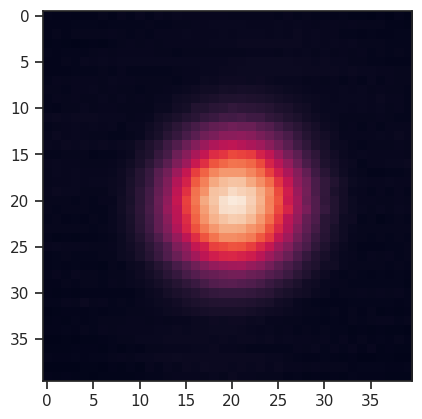

{'adj_cal': np.float64(10.639167096007709), 'raw_cal': np.float64(10.71902960877168), 'chi_beam': np.float64(19.433796652158463), 'pwv': array(0.99306), 'el': 39.99969999999999, 'fwhm': np.float64(1.3274380861979616)} 1.3274380861979616


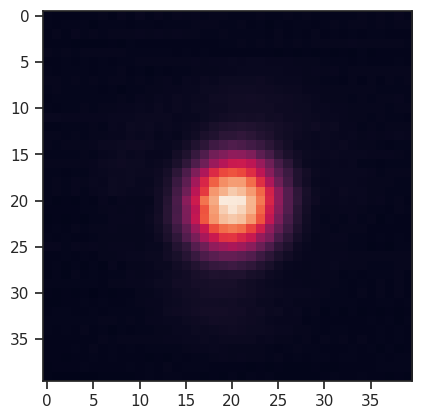

{'adj_cal': np.float64(13.596221876133939), 'raw_cal': np.float64(13.67348037508979), 'chi_beam': np.float64(79.998700688557), 'pwv': array(0.8952), 'el': 39.99969999999999, 'fwhm': np.float64(1.9725294009085204)} 1.9725294009085204


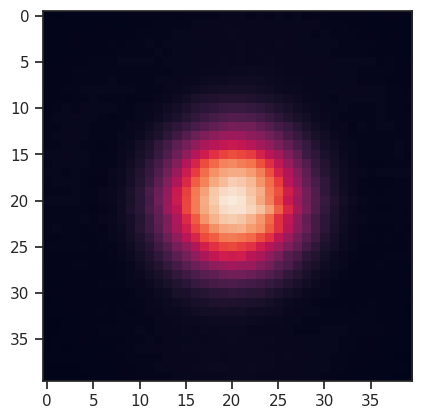

{'adj_cal': np.float64(7.92673132709494), 'raw_cal': np.float64(7.9437189144654985), 'chi_beam': np.float64(51.7897439483516), 'pwv': array(0.8952), 'el': 39.99969999999999, 'fwhm': np.float64(1.3661539764039816)} 1.3661539764039816


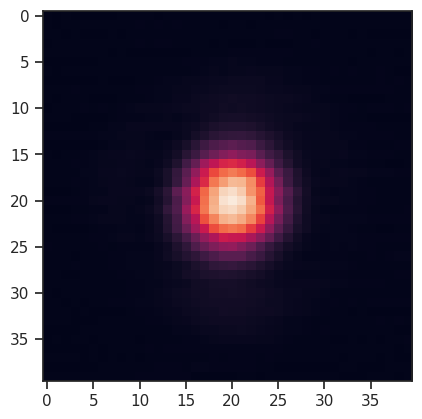

{'adj_cal': np.float64(9.221713784709944), 'raw_cal': np.float64(9.241476617857646), 'chi_beam': np.float64(114.13601204525327), 'pwv': array(0.8987), 'el': 39.99969999999999, 'fwhm': np.float64(1.4964546227875284)} 1.4964546227875284


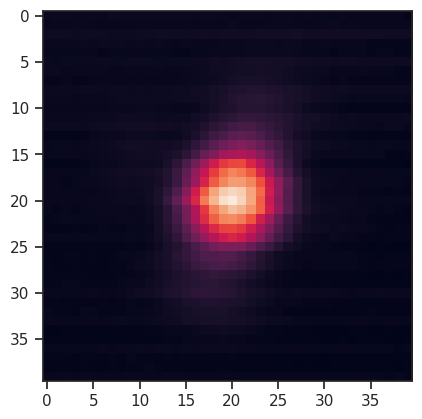

{'adj_cal': np.float64(13.608125276682749), 'raw_cal': np.float64(13.776270907144003), 'chi_beam': np.float64(113.66935479220689), 'pwv': array(1.6778), 'el': 39.99969999999999, 'fwhm': np.float64(2.0918432724087)} 2.0918432724087


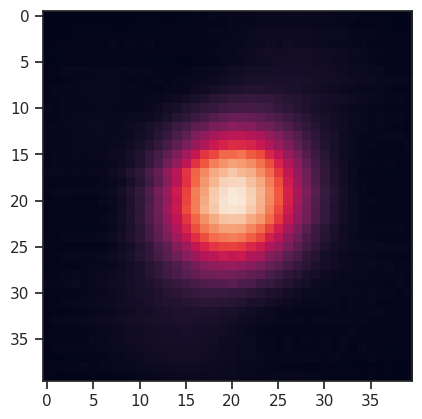

{'adj_cal': np.float64(8.728407694563138), 'raw_cal': np.float64(8.942436796632037), 'chi_beam': np.float64(220.79077524808955), 'pwv': array(1.6778), 'el': 39.99969999999999, 'fwhm': np.float64(1.5448978975180654)} 1.5448978975180654


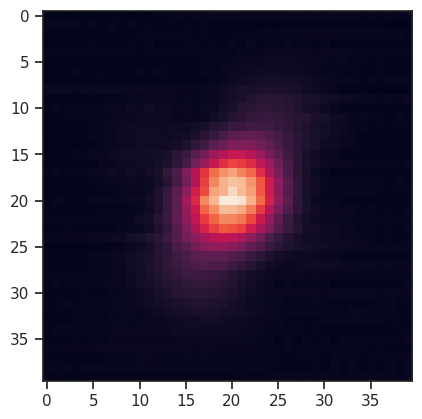

{'adj_cal': np.float64(10.683685870213099), 'raw_cal': np.float64(10.883373168452676), 'chi_beam': np.float64(43.08892261348029), 'pwv': array(1.37022), 'el': 39.99969999999999, 'fwhm': np.float64(1.5008283212141718)} 1.5008283212141718


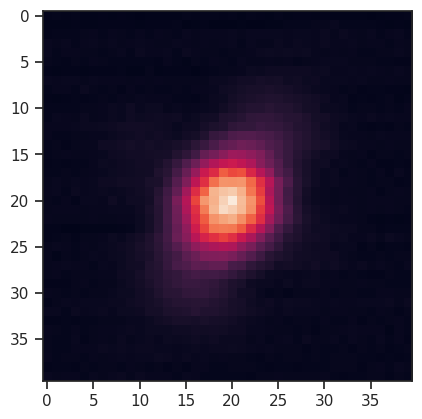

{'adj_cal': np.float64(14.77677131632266), 'raw_cal': np.float64(14.933682328274514), 'chi_beam': np.float64(151.62760983746597), 'pwv': array(1.37022), 'el': 39.99969999999999, 'fwhm': np.float64(2.09053866936562)} 2.09053866936562


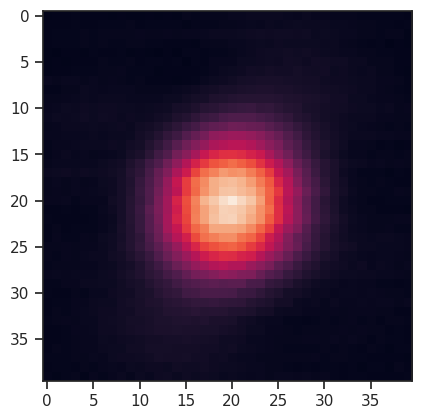

{'adj_cal': np.float64(188.01756194662727), 'raw_cal': np.float64(188.7734400578905), 'chi_beam': np.float64(1.3545138981142975), 'pwv': array(0.5424), 'el': 39.99969999999999, 'fwhm': np.float64(1.9815751887966404)} 1.9815751887966404


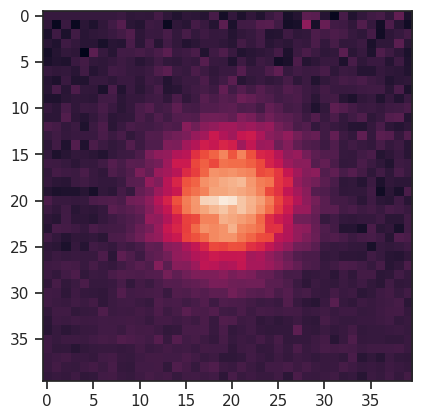

{'adj_cal': np.float64(369.8850757750211), 'raw_cal': np.float64(368.61728700776575), 'chi_beam': np.float64(1.7091239595700294), 'pwv': array(0.5424), 'el': 39.99969999999999, 'fwhm': np.float64(1.56699606099008)} 1.56699606099008


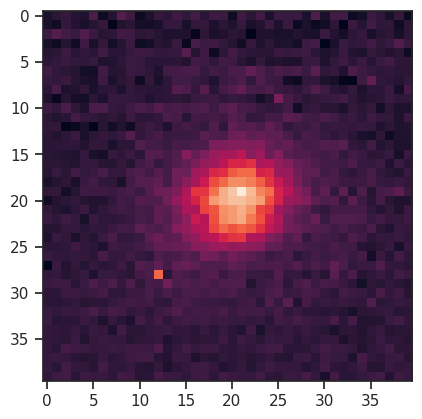

{'adj_cal': np.float64(9.399535508889876), 'raw_cal': np.float64(9.470092773173825), 'chi_beam': np.float64(9.302786075378725), 'pwv': array(1.0198), 'el': 39.99969999999999, 'fwhm': np.float64(1.4833512161380837)} 1.4833512161380837


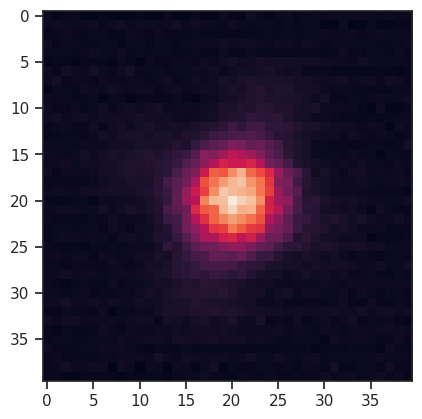

{'adj_cal': np.float64(16.88190587874134), 'raw_cal': np.float64(17.004853211884672), 'chi_beam': np.float64(30.477451208360137), 'pwv': array(1.0198), 'el': 39.99969999999999, 'fwhm': np.float64(2.0880603137407006)} 2.0880603137407006


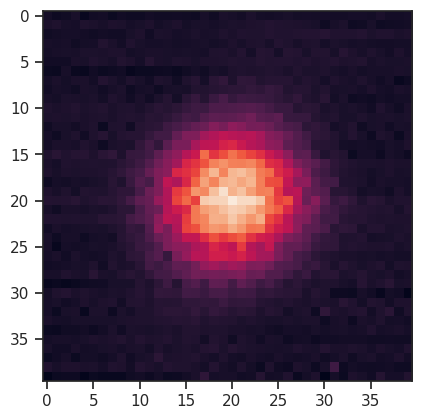

{'adj_cal': np.float64(8.046935328989635), 'raw_cal': np.float64(8.064180522667286), 'chi_beam': np.float64(169.4155355650805), 'pwv': array(0.85852), 'el': 39.99969999999999, 'fwhm': np.float64(1.5113194024471617)} 1.5113194024471617


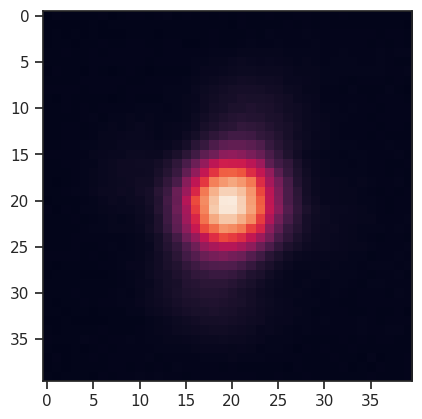

{'adj_cal': np.float64(14.997404388884934), 'raw_cal': np.float64(15.082624898073082), 'chi_beam': np.float64(102.55270600338449), 'pwv': array(0.85852), 'el': 39.99969999999999, 'fwhm': np.float64(2.109953669728112)} 2.109953669728112


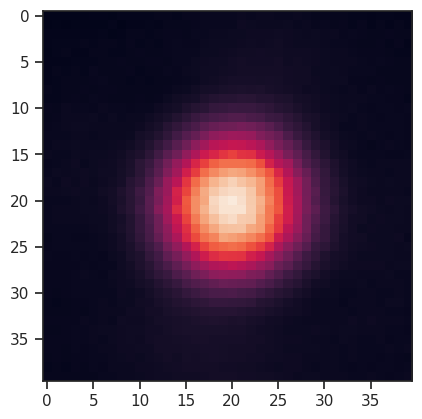

{'adj_cal': np.float64(14.013875353722051), 'raw_cal': np.float64(14.115935430002468), 'chi_beam': np.float64(102.00803205949974), 'pwv': array(0.95764), 'el': 39.99969999999999, 'fwhm': np.float64(2.1035022969046224)} 2.1035022969046224


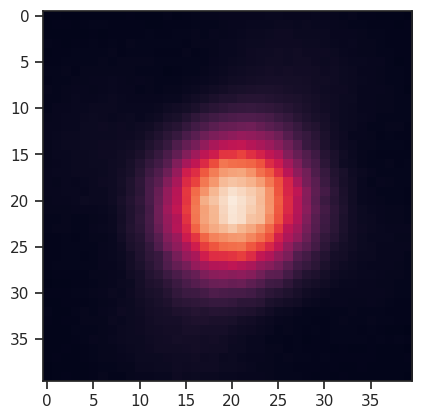

{'adj_cal': np.float64(8.30991194215545), 'raw_cal': np.float64(8.372289987594447), 'chi_beam': np.float64(146.81956391705646), 'pwv': array(0.95764), 'el': 39.99969999999999, 'fwhm': np.float64(1.5357808690970742)} 1.5357808690970742


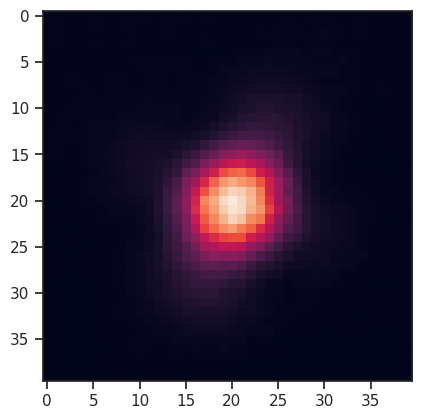

{'adj_cal': np.float64(7.143943538071049), 'raw_cal': np.float64(7.159253551746989), 'chi_beam': np.float64(70.25912831566038), 'pwv': array(0.88568), 'el': 39.99969999999999, 'fwhm': np.float64(1.5279599588516486)} 1.5279599588516486


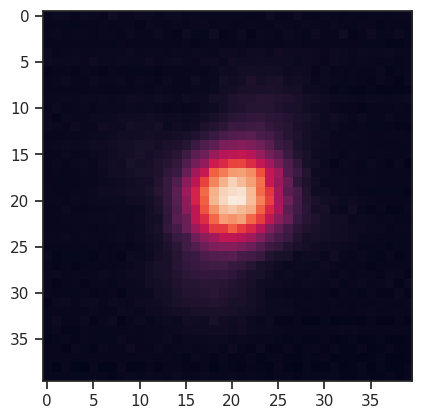

{'adj_cal': np.float64(12.769755974567046), 'raw_cal': np.float64(12.842318204546489), 'chi_beam': np.float64(247.82793035641268), 'pwv': array(0.88568), 'el': 39.99969999999999, 'fwhm': np.float64(2.206757414741961)} 2.206757414741961


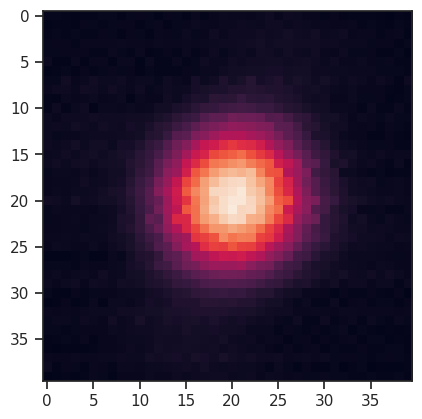

{'adj_cal': np.float64(15.040168435086663), 'raw_cal': np.float64(15.277816387746132), 'chi_beam': np.float64(145.46627212928925), 'pwv': array(2.13182), 'el': 39.99969999999999, 'fwhm': np.float64(2.0511000005958464)} 2.0511000005958464


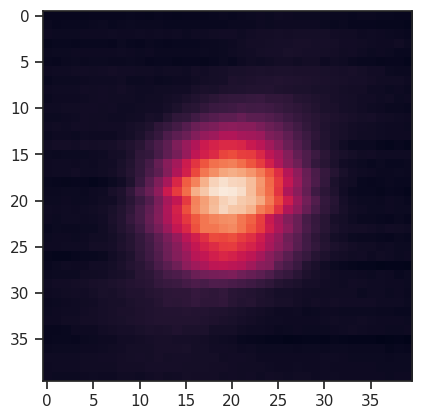

{'adj_cal': np.float64(10.49778879234519), 'raw_cal': np.float64(10.876676226183731), 'chi_beam': np.float64(110.52506596315379), 'pwv': array(2.13182), 'el': 39.99969999999999, 'fwhm': np.float64(1.5034589855939795)} 1.5034589855939795


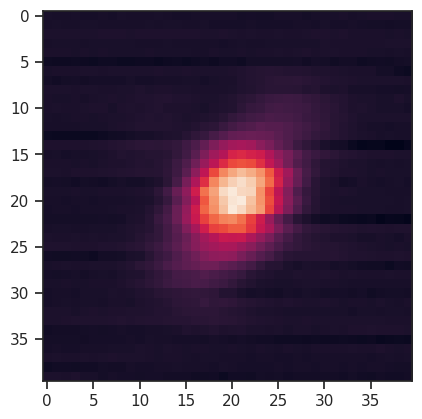

{'adj_cal': np.float64(13.386298707556197), 'raw_cal': np.float64(13.59781405695331), 'chi_beam': np.float64(107.36281439844498), 'pwv': array(2.03942), 'el': 39.99969999999999, 'fwhm': np.float64(2.1098692204867024)} 2.1098692204867024


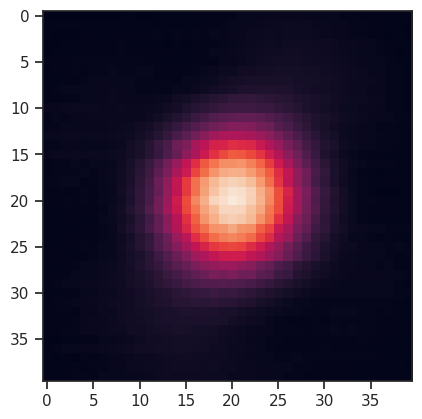

{'adj_cal': np.float64(7.7841710620520015), 'raw_cal': np.float64(8.065118284043333), 'chi_beam': np.float64(242.87847877612785), 'pwv': array(2.03942), 'el': 39.99969999999999, 'fwhm': np.float64(1.5671583259305903)} 1.5671583259305903


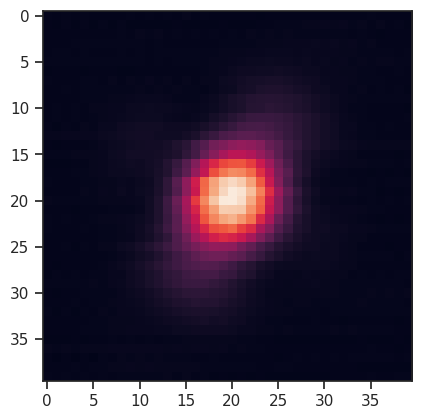

{'adj_cal': np.float64(18.49953439988931), 'raw_cal': np.float64(18.82353888376708), 'chi_beam': np.float64(23.517822713684417), 'pwv': array(2.23136), 'el': 39.99969999999999, 'fwhm': np.float64(2.159458036511628)} 2.159458036511628


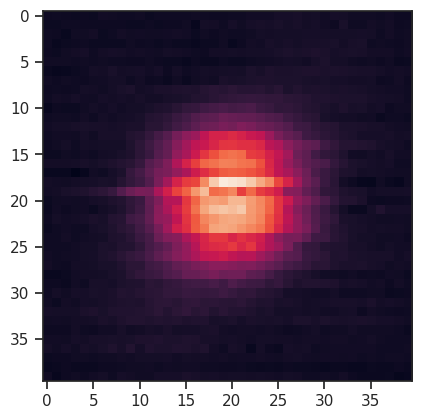

{'adj_cal': np.float64(11.16229116802602), 'raw_cal': np.float64(11.629481740716649), 'chi_beam': np.float64(191.82988757405664), 'pwv': array(2.23136), 'el': 39.99969999999999, 'fwhm': np.float64(1.5117680000083007)} 1.5117680000083007


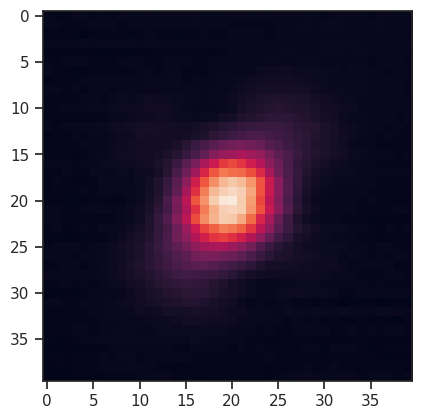

In [67]:
fwhm_cuts = {"090": [1.8, 2.3],
             "150": [1.3, 1.6],
             "220": [0.7, 1.1],
             "280": [0.7, 1.0],
            }

for solved_path in my_paths:
    obs = solved_path.split("/")[-2]
    obs_id = obs.split("_")[1]
    wafer = solved_path.split("/")[-1].split("_")[-3]
    band = solved_path.split("/")[-1].split("_")[-2][1:]
     
    try:
        map_file = solved_path[86:120] 
        fitted_amp = beam_dict[map_file]["amp"]
        data_solid_angle = beam_dict[map_file]["omega"]
        chisred = beam_dict[map_file]["chisred"]
        cal = cal_dict[map_file]
    except:
        continue
    
    
    #if 25 < chisred and chisred < 1000:
    #print("chisqred: ", chisred, cal)
    if obs_id not in T_b.keys():
        print("No Mars data for obs {}".format(obs_id))
        continue

    ufm_type, ufm_band = keys_from_wafer(wafer, band)

    solved = enmap.read_map(solved_path)[0]
    weights = enmap.read_map(solved_path.replace("solved", "weights"))[0][0]
    binned = enmap.read_map(solved_path.replace("solved", "binned"))[0]
    kernel = Gaussian2DKernel(5)
    smoothed = convolve(solved, kernel)
    cent = np.argmax(smoothed)
    cent = np.unravel_index(cent, solved.shape)
    pixsize = np.abs(solved.wcs.wcs.cdelt[0]*60)

    #print(np.var(solved[cent[0]-3:cent[0]+3, cent[1]-3:cent[1]+3]))        
    r = 20
    solved = solved[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
    weights = weights[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
    binned = binned[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]


    pixmap = enmap.pixmap(solved.shape, solved.wcs)
    fitted_amp, shift_x, shift_y, fitted_fwhm, data_solid_angle, chisred, popt, pcov = utils.fit_gauss_pointing(solved, weights, pixmap, make_plots=False)
    if fwhm_cuts[band][1] < fitted_fwhm or fitted_fwhm < fwhm_cuts[band][0]:
        continue
    print(cal, fitted_fwhm)
    plt.imshow(solved)
    plt.show()
    plt.close()


In [ ]:
beam_dict

# Saianeesh good abscals

In [40]:
import datetime as dt
from abscal import data_to_cal_factor

path_mf = "/so/home/saianeesh/data/beams/lat/source_maps/mars/"
paths_mf = glob(path_mf + "*/*/*_solved.fits")
paths_mf = [path for path in paths_mf if "090" in path or "150" in path]

good_cals= {"mv13_f090":['obs_1744925494_lati3_111', 'obs_1744932818_lati3_111', 'obs_1745095053_lati3_111', 'obs_1745098070_lati3_111',
                         'obs_1745105173_lati3_111', 'obs_1745111687_lati3_111', 'obs_1745115361_lati3_111', 'obs_1745545818_lati3_111'],
            "mv13_f150":['obs_1744925494_lati3_111', 'obs_1745032405_lati3_111'],
            "mv14_f090":['obs_1744921072_lati4_111', 'obs_1744923240_lati4_111', 'obs_1744925494_lati4_111', 'obs_1744932818_lati4_111',
                         'obs_1745009698_lati4_111', 'obs_1745018948_lati4_111', 'obs_1745095054_lati4_111', 'obs_1745098070_lati4_111',
                         'obs_1745111687_lati4_111', 'obs_1745115361_lati4_111'],
            "mv14_f150":['obs_1744921072_lati4_111', 'obs_1744923240_lati4_111', 'obs_1744925494_lati4_111', 'obs_1744932818_lati4_111',
                         'obs_1745011941_lati4_111', 'obs_1745032403_lati4_111', 'obs_1745098070_lati4_111', 'obs_1745105173_lati4_111',
                         'obs_1745111687_lati4_111', 'obs_1745115361_lati4_111'],
            "mv20_f090":['obs_1744921072_lati3_111', 'obs_1744923238_lati3_111', 'obs_1744932818_lati3_111', 'obs_1745018948_lati3_111',
                         'obs_1745095053_lati3_111', 'obs_1745111687_lati3_111', 'obs_1745115361_lati3_111'],
            "mv20_f150":['obs_1744923238_lati3_111', 'obs_1744925494_lati3_111', 'obs_1745011941_lati3_111', 'obs_1745018948_lati3_111',
                         'obs_1745032405_lati3_111'],
            "mv21_f090":['obs_1744857536_lati1_111', 'obs_1744932818_lati1_111', 'obs_1745018948_lati1_111', 'obs_1745027702_lati1_111',
                         'obs_1745030065_lati1_111', 'obs_1745089225_lati1_111', 'obs_1745105172_lati1_111', 'obs_1745111687_lati1_111'],
            "mv21_f150":['obs_1744857536_lati1_111', 'obs_1745011941_lati1_111', 'obs_1745018948_lati1_111', 'obs_1745027702_lati1_111',
                         'obs_1745030065_lati1_111', 'obs_1745105172_lati1_111'],
            "mv24_f090":['obs_1744925494_lati1_111', 'obs_1745027702_lati1_111', 'obs_1745030065_lati1_111', 'obs_1745089225_lati1_111',
                         'obs_1745105172_lati1_111', 'obs_1745111687_lati1_111'],
            "mv24_f150":['obs_1744925494_lati1_111', 'obs_1744932818_lati1_111', 'obs_1745011941_lati1_111', 'obs_1745018948_lati1_111',
                         'obs_1745027702_lati1_111', 'obs_1745030065_lati1_111', 'obs_1745089225_lati1_111', 'obs_1745091197_lati1_111'],
            "mv25_f090":['obs_1744857535_lati6_111', 'obs_1744921074_lati6_111', 'obs_1744932820_lati6_111', 'obs_1745009697_lati6_111',
                         'obs_1745027699_lati6_111', 'obs_1745089225_lati6_111', 'obs_1745091198_lati6_111', 'obs_1745098071_lati6_111',
                         'obs_1745111689_lati6_111'],
            "mv25_f150":['obs_1744857535_lati6_111', 'obs_1744921074_lati6_111', 'obs_1744925495_lati6_111', 'obs_1744932820_lati6_111',
                         'obs_1745009697_lati6_111', 'obs_1745011941_lati6_111', 'obs_1745018948_lati6_111', 'obs_1745027699_lati6_111',
                         'obs_1745089225_lati6_111', 'obs_1745091198_lati6_111', 'obs_1745095054_lati6_111', 'obs_1745098071_lati6_111',
                         'obs_1745105172_lati6_111'],
            "mv26_f090":['obs_1744921074_lati6_111', 'obs_1744923236_lati6_111', 'obs_1745009697_lati6_111', 'obs_1745027699_lati6_111',
                         'obs_1745089225_lati6_111', 'obs_1745095054_lati6_111', 'obs_1745111689_lati6_111'],
            "mv26_f150":['obs_1744921074_lati6_111', 'obs_1744923236_lati6_111', 'obs_1744925495_lati6_111', 'obs_1745009697_lati6_111',
                         'obs_1745011941_lati6_111', 'obs_1745027699_lati6_111', 'obs_1745089225_lati6_111', 'obs_1745098071_lati6_111',
                         'obs_1745111689_lati6_111'],
            "mv28_f150":['obs_1745027702_lati1_111'],
            "mv32_f090":['obs_1744921072_lati4_111', 'obs_1744923240_lati4_111', 'obs_1745009698_lati4_111', 'obs_1745011941_lati4_111',
                         'obs_1745095054_lati4_111', 'obs_1745098070_lati4_111', 'obs_1745111687_lati4_111', 'obs_1745115361_lati4_111'],
            "mv32_f150":['obs_1744921072_lati4_111', 'obs_1744923240_lati4_111', 'obs_1744925494_lati4_111', 'obs_1744932818_lati4_111',
                         'obs_1745098070_lati4_111', 'obs_1745105173_lati4_111', 'obs_1745111687_lati4_111', 'obs_1745115361_lati4_111'],
            "mv34_f090":['obs_1744925494_lati3_111', 'obs_1744932818_lati3_111', 'obs_1745018948_lati3_111', 'obs_1745095053_lati3_111',
                         'obs_1745098070_lati3_111', 'obs_1745105173_lati3_111'],
            "mv34_f150":['obs_1744925494_lati3_111', 'obs_1744932818_lati3_111', 'obs_1745018948_lati3_111', 'obs_1745032405_lati3_111',
                         'obs_1745095053_lati3_111', 'obs_1745111687_lati3_111'],
            "mv49_f090":['obs_1744921072_lati4_111', 'obs_1744923240_lati4_111', 'obs_1744925494_lati4_111', 'obs_1745032403_lati4_111',
                         'obs_1745098070_lati4_111', 'obs_1745111687_lati4_111', 'obs_1745115361_lati4_111'],
            "mv49_f150":['obs_1744923240_lati4_111', 'obs_1744925494_lati4_111', 'obs_1745011941_lati4_111', 'obs_1745032403_lati4_111',
                         'obs_1745111687_lati4_111', 'obs_1745115361_lati4_111']
           }

saianeesh_dict = {}

for key in good_cals.keys():
    ufm = key.split("_")[0]
    freq = key.split("_")[1][1:]
    
    cur_cal = 0
    for good_obs in good_cals[key]:
        path = [path for path in paths if good_obs in path and ufm in path and freq in path]
        if len(path) != 1:
            print("Error with obs {}".format(good_obs))
        solved_path = path[0]
        obs = solved_path.split("/")[-2]
        obs_id = obs.split("_")[1]
        wafer = solved_path.split("/")[-1].split("_")[-3]
        band = solved_path.split("/")[-1].split("_")[-2][1:]

        if obs_id not in T_b.keys():
            print("No Mars data for obs {}".format(obs_id))
            continue

        ufm_type, ufm_band = keys_from_wafer(wafer, band)

        solved = enmap.read_map(solved_path)[0]
        weights = enmap.read_map(solved_path.replace("solved", "weights"))[0][0]
        binned = enmap.read_map(solved_path.replace("solved", "binned"))[0]
        kernel = Gaussian2DKernel(5)
        smoothed = convolve(solved, kernel)
        cent = np.argmax(smoothed)
        cent = np.unravel_index(cent, solved.shape)
        pixsize = np.abs(solved.wcs.wcs.cdelt[0]*60)

        r = 20
        solved = solved[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
        weights = weights[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]
        binned = binned[cent[0]-r:cent[0]+r,cent[1]-r:cent[1]+r]

        pixmap = enmap.pixmap(solved.shape, solved.wcs)
        fitted_amp, shift_x, shift_y, fitted_fwhm, data_solid_angle, chisred, popt, pcov = utils.fit_gauss_pointing(solved, weights, pixmap, make_plots=False)
        start_timestamp = int(obs_id)
        end_timestamp = int(obs_id)

        start_date = dt.datetime.utcfromtimestamp(start_timestamp) - dt.timedelta(days=1)
        end_date = dt.datetime.utcfromtimestamp(end_timestamp) + dt.timedelta(days=1)

        pwv_idx = np.where(np.array([np.abs(pwv - fiducial_pwv) < 0.1 for pwv in atmosphere_eff['pwv']]))[0]

        try:
            pwv_obs = pwv(obs_id)
        except:
            print("obs {} outside of pwv range".format(obs_id))
            continue

        ctx = core.Context('/so/metadata/lat/contexts/smurf_detsets.yaml')
        meta = ctx.get_meta(paths[0].split("/")[-2])

        el_obs = meta.obs_info.el_center

        if el_obs > 90:
            el_obs = 180 - el_obs

        obs_idx_pwv = np.where(np.isclose(np.abs(atmosphere_eff['pwv'] - pwv_obs), np.min(np.abs(atmosphere_eff['pwv'] - pwv_obs))))[0][0]
        try:
            obs_key_el = [el for el in atmosphere_eff['LF']["LF_1"].keys() if np.abs(int(el) - el_obs) < 2.5][0]
        except:
            print("El {} for obs {} out of range".format(el_obs, paths[0].split("/")[-2]))
            continue
        t_atm_obs = atmosphere_eff[ufm_type][ufm_band][obs_key_el][obs_idx_pwv]
        t_atm_fiducial = atmosphere_eff[ufm_type][ufm_band][el_key][pwv_idx]
        pwv_adjust = t_atm_fiducial / t_atm_obs

        mars_diameter = utils.get_planet_diameter(int(obs_id), "Mars") # arcsec, we are using exact temperatures

        adjusted_amplitude = fitted_amp * pwv_adjust[0]

        cal_factor = data_to_cal_factor(adjusted_amplitude, data_solid_angle, band, mars_diameter, obs_id)
        raw_factor = data_to_cal_factor(fitted_amp, data_solid_angle, band, mars_diameter, obs_id)
        
        cur_cal += cal_factor
    saianeesh_dict[ufm] = {freq:cur_cal/len(good_cals[key])}


In [42]:
with open("saia_cals.pk", "wb") as f:
    pk.dump(saianeesh_dict, f)